## LOT性质的研究
研究两种LOT的估计方式，以及参数的不同之处。市场收益率使用市值加权平均。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
from mytools.AutoTester import AutoTester

from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from tqdm import tqdm

plt.rcParams['font.sans-serif']=['KaiTi']
plt.rcParams['axes.unicode_minus'] = False

from sklearn.linear_model import LinearRegression

se = SpreadEstimator()

In [2]:
class LOTNet_M(nn.Module):  # 根据市场收益率区分
    def __init__(self, sample_num: int = 1):
        """
        :param sample_num: 样本数量
        """
        super(LOTNet_M, self).__init__()
        self.sample_num = sample_num
        self.sigma = nn.Parameter(0.01 * torch.ones(sample_num))  
        self.beta = nn.Parameter(torch.ones(1, sample_num))
        self.alpha_1 = nn.Parameter(-0.01 * torch.ones(1, sample_num))
        self.alpha_2 = nn.Parameter(0.01 * torch.ones(1, sample_num))
        
    def forward(self, R, R_m):  # 传入的R是seq_length * sample_num，R_m是seq_length * 1
        
        # 如果测试改进的方法，运行下面代码
#         self.alpha_1.data[self.alpha_1.data > 0] = 0
#         self.alpha_2.data[self.alpha_2.data < 0 ]= 0
        
        R_1 = R + self.alpha_1.repeat(len(R), 1) - torch.matmul(R_m, self.beta)
        R_2 = R + self.alpha_2.repeat(len(R), 1) - torch.matmul(R_m, self.beta)
        
        R_t = torch.where(R_m>0, R_2, R_1)
        R_t = torch.sum(R_t**2, dim=0) / (2 * self.sigma ** 2+1e-8)
        # print(R_t.shape)
        return -len(R)/2 * torch.log(1e-8+self.sigma**2) - R_t
    
    def predict(self, R_m):
        return torch.matmul(R_m, self.beta) - torch.where(R_m>0, self.alpha_2.repeat(len(R_m), 1), self.alpha_1.repeat(len(R_m), 1))
    
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        pass
    
    def forward(self, x):
        return -torch.mean(x)
    
    
class LOTNet_R(nn.Module):  # 根据目标收益率区分
    def __init__(self, sample_num: int = 1):
        """
        :param sample_num: 样本数量
        """
        super(LOTNet_R, self).__init__()
        self.sample_num = sample_num
        self.sigma = nn.Parameter(0.01 * torch.ones(sample_num))  
        self.beta = nn.Parameter(torch.ones(1, sample_num))
        self.alpha_1 = nn.Parameter(-0.01 * torch.ones(1, sample_num))
        self.alpha_2 = nn.Parameter(0.01 * torch.ones(1, sample_num))
        
    def forward(self, R, R_m):  # 传入的R是seq_length * sample_num，R_m是seq_length * 1
        # 如果测试改进的方法，运行下面代码
#         self.alpha_1[self.alpha_1 > 0] = 0
#         self.alpha_2[self.alpha_2 < 0] = 0
        
        R_1 = R + self.alpha_1.repeat(len(R), 1) - torch.matmul(R_m, self.beta)
        R_2 = R + self.alpha_2.repeat(len(R), 1) - torch.matmul(R_m, self.beta)
        R_t = torch.where(R>0, R_2, R_1)

        R_t = torch.sum(R_t**2, dim=0) / (2 * self.sigma ** 2+1e-8)
        # print(R_t.shape)
        return -len(R)/2 * torch.log(1e-8+self.sigma**2) - R_t
    
    def predict(self, R, R_m):
        return torch.matmul(R_m, self.beta) - torch.where(R>0, self.alpha_2.repeat(len(R_m), 1), self.alpha_1.repeat(len(R_m), 1))
    
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        pass
    
    def forward(self, x):
        return -torch.mean(x)

In [6]:
# 获得R_m和每个股票的日收益率
fml = 'tspct{close,1}'
stats, ret = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread')
ret = ret.astype(np.float32)
# ret[np.isnan(ret)] = 0
R_m = np.zeros(len(ret), dtype=np.float32)
R_m[1:] = np.nansum(ret[1:]*se.data.data_dic['cap'][1:], axis=1) / np.nansum(se.data.data_dic['cap'][1:], axis=1)
R_m = R_m.reshape(-1,1)

mean corr: -0.0059, positive_corr_ratio: 0.4732, corr_IR: -0.0531


### 首先对每一只股票做回归，看beta和R square

In [54]:
lr = LinearRegression()
betas = []
R2 = []
for i in tqdm(range(2081)):
    lr.fit(R_m[20:],ret[20:,i])
    betas.append(lr.coef_[0])
    R2.append(1-np.std(ret[20:,i]-lr.predict(R_m[20:]))/np.std(ret[20:,i]))
betas = np.array(betas)
R2 = np.array(R2)

100%|████████████████████████████████████████████████████████████████████████████| 2081/2081 [00:00<00:00, 3037.40it/s]


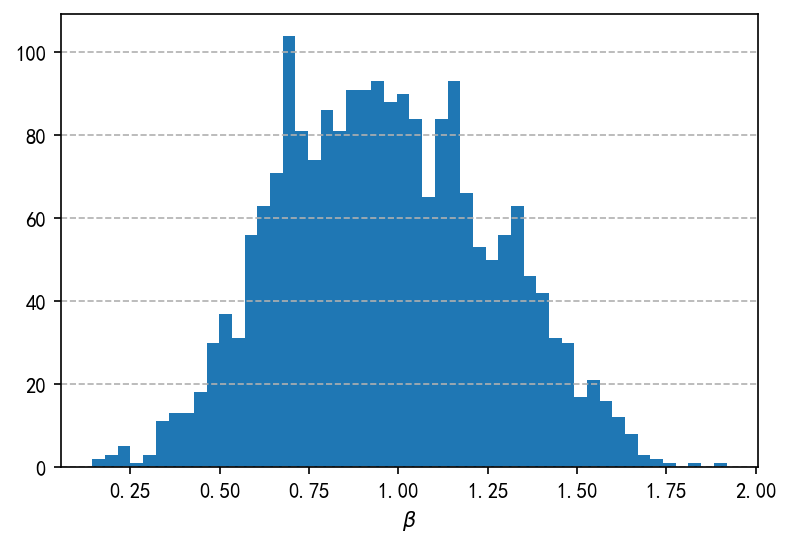

0.9658244


In [55]:
plt.figure(dpi=150)
plt.hist(betas, rwidth=1, bins=50)
plt.grid(axis='y', linestyle='--')
plt.xlabel(r'$\beta$')
plt.show()
print(np.mean(betas))

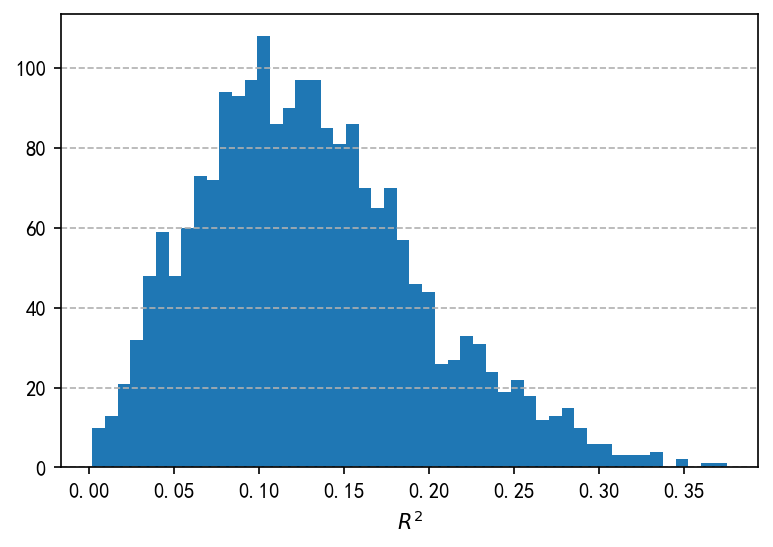

0.13078517429190492


In [56]:
plt.figure(dpi=150)
plt.hist(R2, rwidth=1, bins=50)
plt.grid(axis='y', linestyle='--')
plt.xlabel(r'$R^2$')
plt.show()
print(np.mean(R2))

### 如果修改模型，运行下面的代码

In [106]:
# 获得R_m和每个股票的日收益率，R减去回归的截距项
fml = 'tspct{close,1}'
stats, ret = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread')
ret = ret.astype(np.float32)
# ret[np.isnan(ret)] = 0
R_m = np.zeros(len(ret), dtype=np.float32)
R_m[1:] = np.nansum(ret[1:]*se.data.data_dic['cap'][1:], axis=1) / np.nansum(se.data.data_dic['cap'][1:], axis=1)
R_m = R_m.reshape(-1,1)

lr = LinearRegression()
betas = []
R2 = []
for i in tqdm(range(2081)):
    lr.fit(R_m[20:],ret[20:,i])
    
    betas.append(lr.coef_[0])
    R2.append(1-np.std(ret[20:,i]-lr.predict(R_m[20:]))/np.std(ret[20:,i]))
    ret[20:,i] -= lr.intercept_
betas = np.array(betas)
R2 = np.array(R2)

mean corr: -0.0059, positive_corr_ratio: 0.4732, corr_IR: -0.0531


100%|████████████████████████████████████████████████████████████████████████████| 2081/2081 [00:00<00:00, 3165.75it/s]


### 然后再用X-split做一个LOT，同样比较beta和R^2

In [122]:
device = 'cuda'
model_M = LOTNet_M(2081).to(device)
optimizer = torch.optim.AdamW(model_M.parameters(), lr=1e-2, weight_decay=0)
loss_func = MyLoss()

r_m = torch.Tensor(R_m).to(device)
r = torch.Tensor(ret).to(device)

t = time()

for i in tqdm(range(1000)):
    model_M.train()
    optimizer.zero_grad()
    loss = loss_func(model_M(r[20:], r_m[20:]))
    loss.backward()
    optimizer.step()
#     if (i + 1) % 1000 == 0:
#         # print('epoch {}'.format(i + 1))
#         print('loss: {:.4f}, time used: {:.4f}s'.format(float(loss), time()-t))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 238.24it/s]


In [123]:
betas_LOT_x = model_M.beta.detach().cpu().numpy()[0]
pr = model_M.predict(r_m[20:]).detach().cpu().numpy()
R2_LOT_x = np.array([1-np.std(ret[20:,i]-pr[:,i])/np.std(ret[20:,i]) for i in range(2081)])

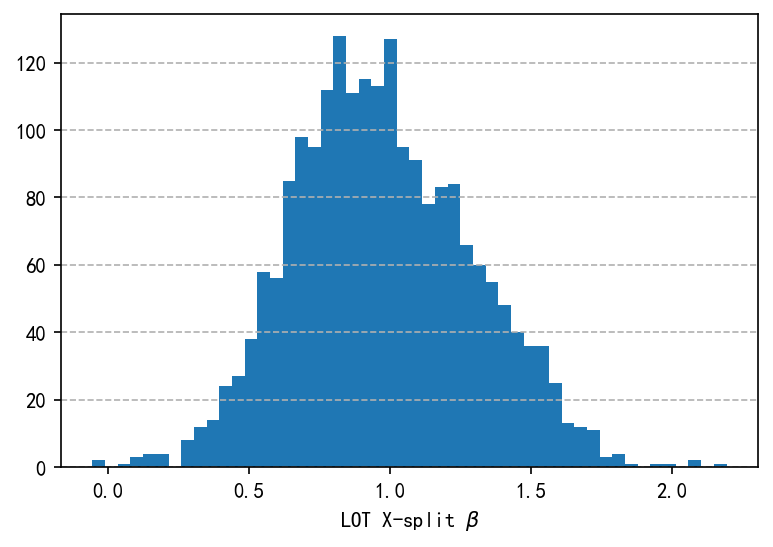

0.97385687


In [124]:
plt.figure(dpi=150)
plt.hist(betas_LOT_x, rwidth=1, bins=50)
plt.grid(axis='y', linestyle='--')
plt.xlabel(r'LOT X-split $\beta$')
plt.show()
print(np.mean(betas_LOT_x))

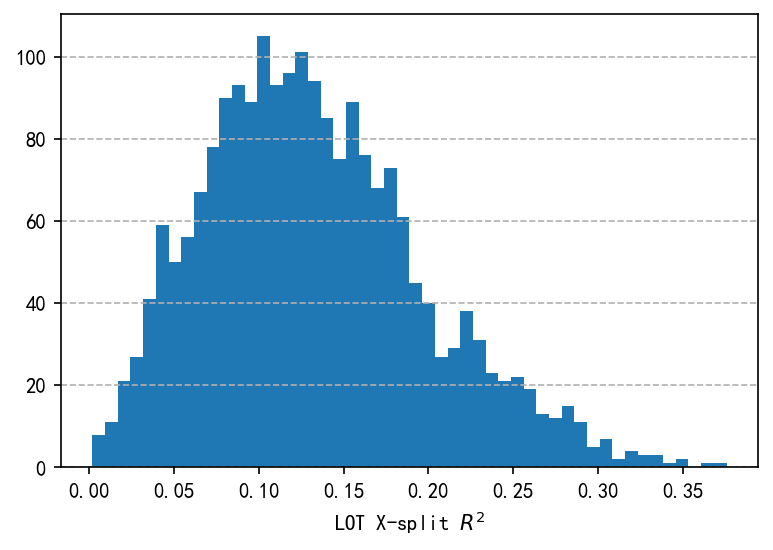

0.13273811996240906


In [125]:
plt.figure(dpi=150)
plt.hist(R2_LOT_x, rwidth=1, bins=50)
plt.grid(axis='y', linestyle='--')
plt.xlabel(r'LOT X-split $R^2$')
plt.show()
print(np.mean(R2_LOT_x))

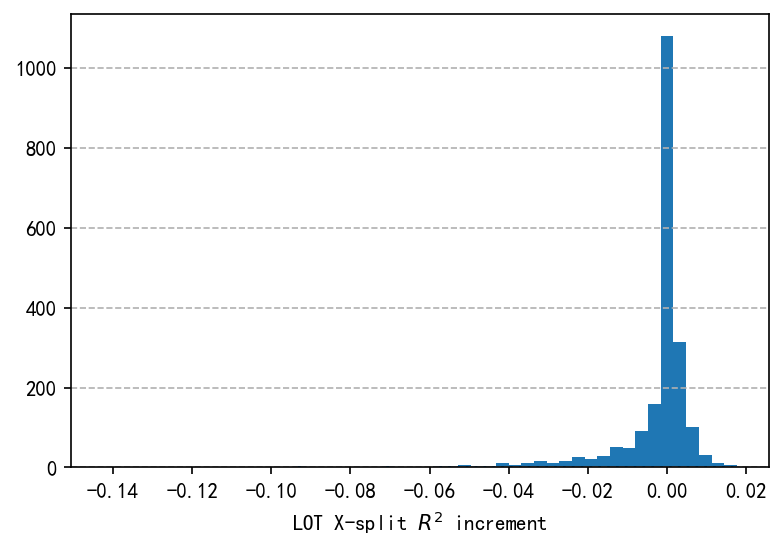

In [118]:
plt.figure(dpi=150)
plt.hist(R2_LOT_x-R2, rwidth=1, bins=50)
plt.grid(axis='y', linestyle='--')
plt.xlabel(r'LOT X-split $R^2$ increment')
plt.show()

In [126]:
print(torch.mean(model_M.alpha_1)*1e4)
print(torch.sum(model_M.alpha_1<0)/2081) 
print()
print(torch.mean(model_M.alpha_2)*1e4)
print(torch.sum(model_M.alpha_2>0)/2081) 
print()
print(torch.sum((model_M.alpha_2-model_M.alpha_1)>0)/2081) 
print(torch.sum((model_M.alpha_2<0) & (model_M.alpha_1>0))/2081) 

tensor(-1.7431, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5469, device='cuda:0')

tensor(1.5934, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5464, device='cuda:0')

tensor(0.5469, device='cuda:0')
tensor(0.4531, device='cuda:0')


### 然后再用Y-split做一个LOT，同样比较beta和R^2

In [128]:
device = 'cuda'
model_R = LOTNet_R(2081).to(device)
optimizer = torch.optim.AdamW(model_R.parameters(), lr=1e-2, weight_decay=0)
loss_func = MyLoss()

r_m = torch.Tensor(R_m).to(device)
r = torch.Tensor(ret).to(device)

t = time()

for i in tqdm(range(1000)):
    model_R.train()
    optimizer.zero_grad()
    loss = loss_func(model_R(r[20:], r_m[20:]))
    loss.backward()
    optimizer.step()
#     if (i + 1) % 1000 == 0:
#         # print('epoch {}'.format(i + 1))
#         print('loss: {:.4f}, time used: {:.4f}s'.format(float(loss), time()-t))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 243.62it/s]


In [129]:
betas_LOT_y = model_R.beta.detach().cpu().numpy()[0]
pr = model_R.predict(r[20:], r_m[20:]).detach().cpu().numpy()
R2_LOT_y = np.array([1-np.std(ret[20:,i]-pr[:,i])/np.std(ret[20:,i]) for i in range(2081)])
print(np.mean(betas_LOT_y))

0.4232694


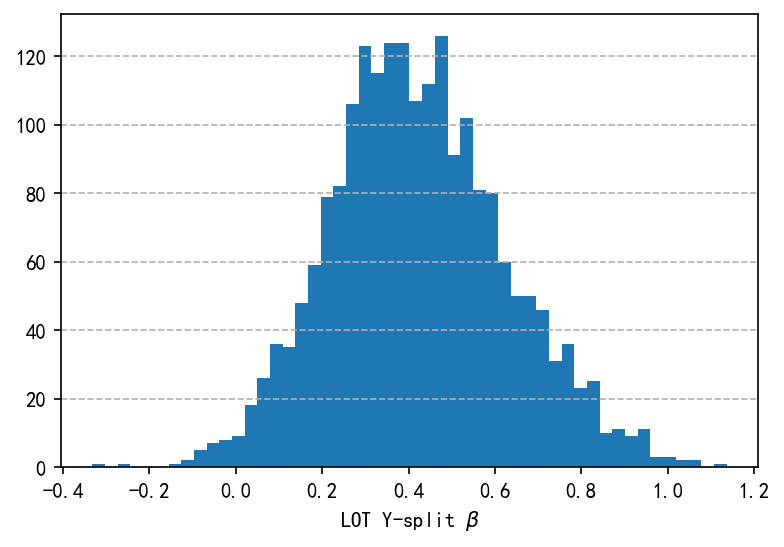

0.34000278223826874


In [130]:
plt.figure(dpi=150)
plt.hist(betas_LOT_y, rwidth=1, bins=50)
plt.grid(axis='y', linestyle='--')
plt.xlabel(r'LOT Y-split $\beta$')
plt.show()
print(np.mean(R2_LOT_y))

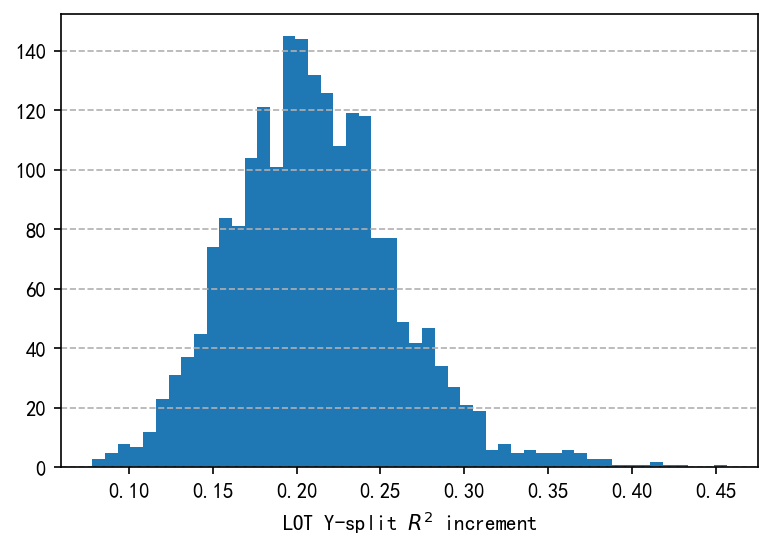

In [82]:
plt.figure(dpi=150)
plt.hist(R2_LOT_y-R2, rwidth=1, bins=50)
plt.grid(axis='y', linestyle='--')
plt.xlabel(r'LOT Y-split $R^2$ increment')
plt.show()

In [131]:
print(torch.mean(model_R.alpha_1)*1e2)
print(torch.sum(model_R.alpha_1<0)/2081) 
print(torch.mean(model_R.alpha_2)*1e2)
print(torch.sum(model_R.alpha_2>0)/2081) 
print(torch.sum((model_R.alpha_2-model_R.alpha_1)>0)/2081) 

tensor(1.8979, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0., device='cuda:0')
tensor(-2.0341, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


### 用LOT X-split来估计价差

In [13]:
device = 'cuda'
model = LOTNet_M(2081).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=0)
loss_func = MyLoss()

r_m = torch.Tensor(R_m).to(device)
r = torch.Tensor(ret).to(device)

# R_m = torch.Tensor(R_m[1:51]).unsqueeze(-1).to(device)
# R = torch.Tensor(ret[1:51]).to(device)

signal = np.zeros((243, 2081))
t = time()
for j in tqdm(range(21, 243)):
    model = LOTNet_M(2081).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)
    for i in range(1000):
        model.train()
        optimizer.zero_grad()
        loss = loss_func(model(r[j-20:j+1], r_m[j-20:j+1]))
        loss.backward()
        optimizer.step()
#         if (i + 1) % 100 == 0:
#             print('epoch {}'.format(i + 1))
#             print('loss: {:.4f}, time used: {:.4f}s'.format(float(loss), time()-t))
    # model.eval()
    signal[j] = (model.alpha_2 - model.alpha_1).detach().cpu().numpy()
#     if j % 10 == 0:
#         print('{} done. time used: {:.4f}s'.format(j, time()-t))

100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [05:31<00:00,  1.49s/it]


### 测试修改后的LOT

In [4]:
# 获得R_m和每个股票的日收益率，R减去回归的截距项
fml = 'tspct{close,1}'
stats, ret = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread')
ret = ret.astype(np.float32)
# ret[np.isnan(ret)] = 0
R_m = np.zeros(len(ret), dtype=np.float32)
R_m[1:] = np.nansum(ret[1:]*se.data.data_dic['cap'][1:], axis=1) / np.nansum(se.data.data_dic['cap'][1:], axis=1)
R_m = R_m.reshape(-1,1)

lr = LinearRegression()
betas = []
R2 = []
for i in tqdm(range(2081)):
    lr.fit(R_m[20:],ret[20:,i])
    
    betas.append(lr.coef_[0])
    R2.append(1-np.std(ret[20:,i]-lr.predict(R_m[20:]))/np.std(ret[20:,i]))
    ret[20:,i] -= lr.intercept_
betas = np.array(betas)
R2 = np.array(R2)

mean corr: -0.0059, positive_corr_ratio: 0.4732, corr_IR: -0.0531


100%|████████████████████████████████████████████████████████████████████████████| 2081/2081 [00:00<00:00, 3151.90it/s]


In [44]:
def get_xy(x,y,univ):
    xx = []
    yy = []
    for i in range(len(x)):
        se = (~np.isnan(x[i])) & univ[i] & (~np.isnan(y[i]))
        if np.sum(se) == 0:
            continue
        xx.append(x[i:i+1, se].T)
        yy.append(y[i,se])
    return np.vstack(xx), np.hstack(yy)
univ = ~np.isnan(se.data.data_dic['close'])  # 合法的univ

In [15]:
raw_signal = signal.copy()
signal[signal<0] = 0

In [18]:
# 只在价格某个价格范围内进行比较
# 显然对于高价股的估计更加准确
# 暂时按照20元的阈值进行剔除
corr = []
sig = []
est = []
for i in range(21,240):
    sp = np.mean(se.data.spread_dic['relative_spread'][i-20+1:i+1], axis=0)
    top = (~np.isnan(sp)) & (~np.isnan(signal[i])) & (np.mean(se.data.data_dic['close'][i-19:i],axis=0)>25)
    # print(np.sum(top))
    sig += list(signal[i,top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[i,top])[0,1])
# plt.scatter(est,sig)
print('relative_spread cs: {:.4f}'.format(np.mean(corr)))

corr = []
sig = []
est = []
new_sp = se.data.spread_dic['relative_spread'].copy()
for i in range(se.data.spread_dic['relative_spread'].shape[0]):
    if i < 20 - 1:
        continue
    new_sp[i] = np.mean(se.data.spread_dic['relative_spread'][i-19:i+1], axis=0)
for i in range(new_sp.shape[1]):
    sp = new_sp[:,i]
    top = (~np.isnan(sp)) & (~np.isnan(signal[:,i])) & (se.data.data_dic['close'][:,i] > 25)
    if np.nanmean(se.data.data_dic['close'][:,i]) < 25:
        continue
    sig += list(signal[:,i][top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[:,i][top])[0,1])
# plt.scatter(est,sig)
print('relative_spread ts: {:.4f}'.format(np.nanmean(corr)))

corr = []
sig = []
est = []
for i in range(21,240):
    sp = np.mean(se.data.spread_dic['vol_wtd_rel_bas'][i-20+1:i+1], axis=0)
    top = (~np.isnan(sp)) & (~np.isnan(signal[i])) & (np.mean(se.data.data_dic['close'][i-19:i],axis=0)>25)
    # print(np.sum(top))
    sig += list(signal[i,top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[i,top])[0,1])
# plt.scatter(est,sig)
print('vol_wtd_rel_bas cs: {:.4f}'.format(np.mean(corr)))
      
corr = []
sig = []
est = []
new_sp = se.data.spread_dic['vol_wtd_rel_bas'].copy()
for i in range(se.data.spread_dic['vol_wtd_rel_bas'].shape[0]):
    if i < 20 - 1:
        continue
    new_sp[i] = np.mean(se.data.spread_dic['vol_wtd_rel_bas'][i-19:i+1], axis=0)
for i in range(new_sp.shape[1]):
    sp = new_sp[:,i]
    top = (~np.isnan(sp)) & (~np.isnan(signal[:,i])) & (se.data.data_dic['close'][:,i] > 25)
    if np.nanmean(se.data.data_dic['close'][:,i]) < 25:
        continue
    sig += list(signal[:,i][top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[:,i][top])[0,1])
# plt.scatter(est,sig)
print('vol_wtd_rel_bas ts: {:.4f}'.format(np.nanmean(corr)))

relative_spread cs: 0.0178
relative_spread ts: 0.0162
vol_wtd_rel_bas cs: 0.0191
vol_wtd_rel_bas ts: 0.0132


In [47]:
print('cs_sp')
stats = AT.test(signal[21:], se.data.spread[21:240], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[51:], se.data.spread[21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_sp')
stats = AT.test(signal[21:], se.data.spread[21:240], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread[21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_vol_sp')
stats = AT.test(signal[21:], se.data.spread_dic['vol_wtd_bas'][21:240], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()


print('ts_vol_sp')
stats = AT.test(signal[21:], se.data.spread_dic['vol_wtd_bas'][21:240], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

cs_sp
mean corr: 0.0112, positive_corr_ratio: 0.5982, corr_IR: 0.2249
0.023341358155637867

ts_sp
mean corr: 0.0338, positive_corr_ratio: 0.5291, corr_IR: 0.1712
0.02291116066893888

cs_vol_sp
mean corr: 0.0169, positive_corr_ratio: 0.6301, corr_IR: 0.3212
0.0010643690418123538

ts_vol_sp
mean corr: 0.0402, positive_corr_ratio: 0.5526, corr_IR: 0.2140
0.0010643690418123538



### LOT Y-split

In [19]:
device = 'cuda'
model = LOTNet_R(2081).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=0)
loss_func = MyLoss()

r_m = torch.Tensor(R_m).to(device)
r = torch.Tensor(ret).to(device)

# R_m = torch.Tensor(R_m[1:51]).unsqueeze(-1).to(device)
# R = torch.Tensor(ret[1:51]).to(device)

signal = np.zeros((243, 2081))
t = time()
for j in tqdm(range(21, 243)):
    model = LOTNet_R(2081).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)
    for i in range(1000):
        model.train()
        optimizer.zero_grad()
        loss = loss_func(model(r[j-20:j+1], r_m[j-20:j+1]))
        loss.backward()
        optimizer.step()
#         if (i + 1) % 100 == 0:
#             print('epoch {}'.format(i + 1))
#             print('loss: {:.4f}, time used: {:.4f}s'.format(float(loss), time()-t))
    # model.eval()
    signal[j] = (model.alpha_2 - model.alpha_1).detach().cpu().numpy()
#     if j % 10 == 0:
#         print('{} done. time used: {:.4f}s'.format(j, time()-t))

100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [05:27<00:00,  1.47s/it]


In [21]:
raw_signal = signal.copy()
signal[signal<0] = 0

In [23]:
signal = raw_signal.copy()

In [24]:
# 只在价格某个价格范围内进行比较
# 显然对于高价股的估计更加准确
# 暂时按照20元的阈值进行剔除
corr = []
sig = []
est = []
for i in range(21,240):
    sp = np.mean(se.data.spread_dic['relative_spread'][i-20+1:i+1], axis=0)
    top = (~np.isnan(sp)) & (~np.isnan(signal[i])) & (np.mean(se.data.data_dic['close'][i-19:i],axis=0)>25)
    # print(np.sum(top))
    sig += list(signal[i,top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[i,top])[0,1])
# plt.scatter(est,sig)
print('relative_spread cs: {:.4f}'.format(np.mean(corr)))

corr = []
sig = []
est = []
new_sp = se.data.spread_dic['relative_spread'].copy()
for i in range(se.data.spread_dic['relative_spread'].shape[0]):
    if i < 20 - 1:
        continue
    new_sp[i] = np.mean(se.data.spread_dic['relative_spread'][i-19:i+1], axis=0)
for i in range(new_sp.shape[1]):
    sp = new_sp[:,i]
    top = (~np.isnan(sp)) & (~np.isnan(signal[:,i])) & (se.data.data_dic['close'][:,i] > 25)
    if np.nanmean(se.data.data_dic['close'][:,i]) < 25:
        continue
    sig += list(signal[:,i][top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[:,i][top])[0,1])
# plt.scatter(est,sig)
print('relative_spread ts: {:.4f}'.format(np.nanmean(corr)))

corr = []
sig = []
est = []
for i in range(21,240):
    sp = np.mean(se.data.spread_dic['vol_wtd_rel_bas'][i-20+1:i+1], axis=0)
    top = (~np.isnan(sp)) & (~np.isnan(signal[i])) & (np.mean(se.data.data_dic['close'][i-19:i],axis=0)>25)
    # print(np.sum(top))
    sig += list(signal[i,top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[i,top])[0,1])
# plt.scatter(est,sig)
print('vol_wtd_rel_bas cs: {:.4f}'.format(np.mean(corr)))
      
corr = []
sig = []
est = []
new_sp = se.data.spread_dic['vol_wtd_rel_bas'].copy()
for i in range(se.data.spread_dic['vol_wtd_rel_bas'].shape[0]):
    if i < 20 - 1:
        continue
    new_sp[i] = np.mean(se.data.spread_dic['vol_wtd_rel_bas'][i-19:i+1], axis=0)
for i in range(new_sp.shape[1]):
    sp = new_sp[:,i]
    top = (~np.isnan(sp)) & (~np.isnan(signal[:,i])) & (se.data.data_dic['close'][:,i] > 25)
    if np.nanmean(se.data.data_dic['close'][:,i]) < 25:
        continue
    sig += list(signal[:,i][top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[:,i][top])[0,1])
# plt.scatter(est,sig)
print('vol_wtd_rel_bas ts: {:.4f}'.format(np.nanmean(corr)))

relative_spread cs: -0.0389
relative_spread ts: -0.0276
vol_wtd_rel_bas cs: -0.0767
vol_wtd_rel_bas ts: -0.0578
